In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from numpy.fft import fft,fftshift
plt.rcParams.update({'font.size': 16})

In [2]:
%matplotlib notebook

In [3]:
SW=200
TD=640
SI=2048
SF=150
O=100


SWH=SF*SW
dt=1/SWH

artifacts=.03*(1)

In [4]:
A,delta1,lw1,delta2,lw2=[[] for _ in range(5)]
with open('peaks.txt','r') as f:
    for line in f:
        i,d1,l1,d2,l2=[float(x) for x in line.strip().split('\t')]
        A.append(i)
        delta1.append(d1)
        lw1.append(l1)
        delta2.append(d2)
        lw2.append(l2)
A,delta1,lw1,delta2,lw2=[np.array(x) for x in [A,delta1,lw1,delta2,lw2]]


vr=12000
i=np.logical_and(delta1>140,delta2>140)
A=np.concatenate([A,.1*A[i],.1*A[i],.03*A[i],.03*A[i],.03*A[i]])
delta1=np.concatenate([delta1,delta1[i],delta1[i]-vr/SF,delta1[i],delta1[i]-2*vr/SF,delta1[i]-vr/SF])
delta2=np.concatenate([delta2,delta2[i]-vr/SF,delta2[i],delta2[i]-2*vr/SF,delta2[i],delta2[i]-vr/SF])
lw1=np.concatenate([lw1,lw1[i],lw1[i],lw1[i],lw1[i],lw1[i]])
lw2=np.concatenate([lw2,lw2[i],lw2[i],lw2[i],lw2[i],lw2[i]])


nl=A.max()/3

# States

In [5]:
t=np.arange(TD)*dt

Ire=np.zeros((TD,TD),dtype=complex)
Iim=np.zeros((TD,TD),dtype=complex)

phase=2*np.pi*np.random.rand(A.size) #Random phase of artifacts

for i,d1,l1,d2,l2,p in zip(A,delta1,lw1,delta2,lw2,phase):
    Ire+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)
    Iim+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    
    #Artifacts
    Ire+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    Iim+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03

# Noise
Ire+=np.random.randn(*Ire.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl
Iim+=np.random.randn(*Ire.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl

### Processing

In [6]:
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
Ire_a=((Ire*apod).T*apod).T
Iim_a=((Iim*apod).T*apod).T
Ire_a[0]/=2
Iim_a[0]/=2

SIre=fft(Ire_a.T,SI)
SIim=fft(Iim_a.T,SI)

SIre[0]/=2
SIim[0]/=2

S=fftshift(fft((SIre.real+1j*SIim.real).T,SI)).real

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


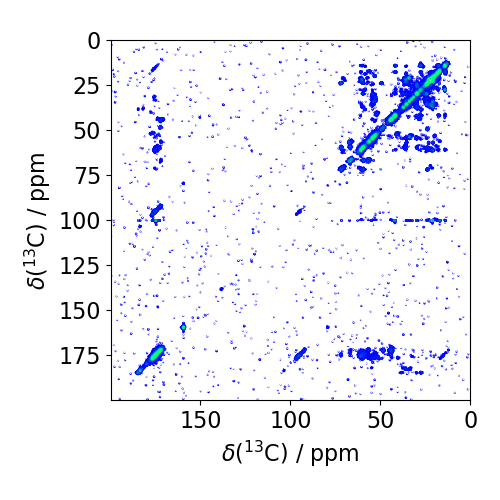

In [8]:
fig,ax=plt.subplots()
levels=np.logspace(np.log10(S.max()*A.min()/A.max()*3.5),np.log10(S.max()/10),25)
ax.contour(f/SF+O,f/SF+O,S.real.T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
fig.set_size_inches([5,5])
fig.tight_layout()

# TPPI

In [9]:
t=np.arange(TD)*dt
t1=np.arange(2*TD)*dt/2

I=np.zeros((TD,TD*2),dtype=complex)
phase=2*np.pi*np.random.rand(A.size) #Random phase of artifacts
    
for i,d1,l1,d2,l2,p in zip(A,delta1,lw1,delta2,lw2,phase):
    I[:,0::4]+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t1[0::4]).real)
    I[:,1::4]+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t1[1::4]).imag)
    I[:,2::4]+=-i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t1[2::4]).real)
    I[:,3::4]+=-i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t1[3::4]).imag)
    
    # Artifacts
    I=(I.T+i*np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)*.03).T

# Noise
I+=np.random.randn(*I.shape)*np.exp(1j*2*np.pi*np.random.rand(*I.shape))*nl

In [10]:
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
apod1=np.cos(np.arange(TD*2)/TD*np.pi)**2
I_a=((I*apod1).T*apod).T
I_a[0]/=2

S0=fft(I_a.T,SI)

S0[0]/=2

S=fftshift(fft((S0.real).T,SI*2)).real

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

f1=1/(dt)*np.linspace(-1,1,SI*2)
f1-=np.diff(f1[:2])/2

<IPython.core.display.Javascript object>


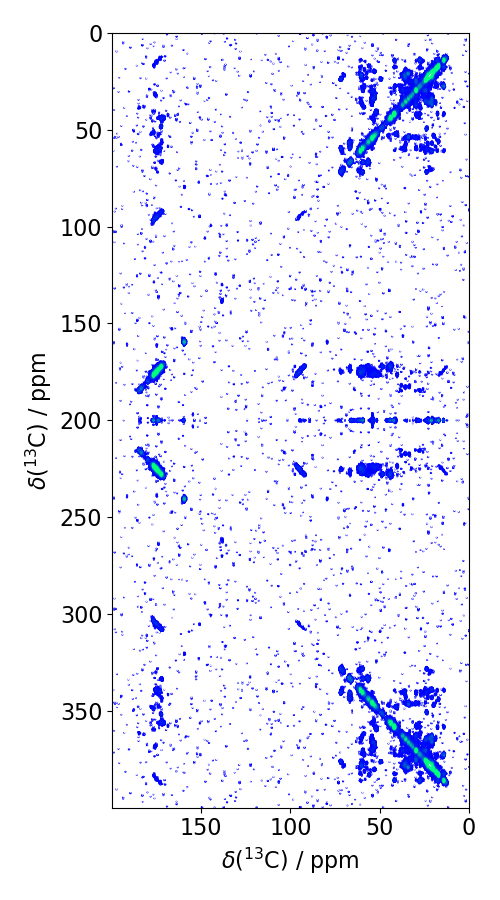

In [11]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f1/SF+SW/2+O,S.real.T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
# ax.set_aspect('equal', 'box')
fig.set_size_inches([5,9])
fig.tight_layout()

<IPython.core.display.Javascript object>


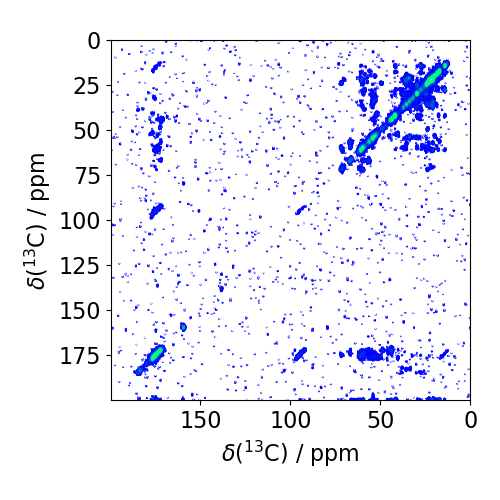

In [12]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,S.real.T[:SI],levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
fig.set_size_inches([5,5])
fig.tight_layout()

# States-TPPI

In [13]:
t=np.arange(TD)*dt

Ire=np.zeros((TD,TD),dtype=complex)
Iim=np.zeros((TD,TD),dtype=complex)

phase=2*np.pi*np.random.rand(A.size) #Random phase of artifacts
    
for i,d1,l1,d2,l2,p in zip(A,delta1,lw1,delta2,lw2,phase):
    Ire[:,0::2]+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t[0::2]).real)
    Iim[:,0::2]+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t[0::2]).imag)
    Ire[:,1::2]+=-i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t[1::2]).real)
    Iim[:,1::2]+=-i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t[1::2]).imag)
    #Artifacts

    Ire+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    Iim+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    
Ire+=np.random.randn(*Ire.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl
Iim+=np.random.randn(*Ire.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl

In [14]:
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
Ire_a=((Ire*apod).T*apod).T
Iim_a=((Iim*apod).T*apod).T
Ire_a[0]/=2
Iim_a[0]/=2

SIre=fft(Ire_a.T,SI)
SIim=fft(Iim_a.T,SI)

SIre[0]/=2
SIim[0]/=2

S=fftshift(fft((SIre.real+1j*SIim.real).T,SI)).real

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


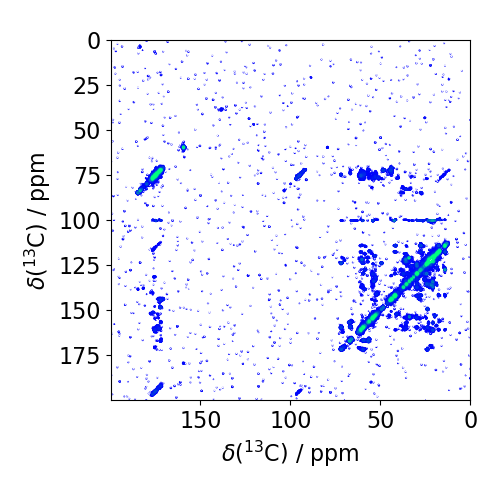

In [15]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,S.T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
fig.set_size_inches([5,5])
fig.tight_layout()

<IPython.core.display.Javascript object>


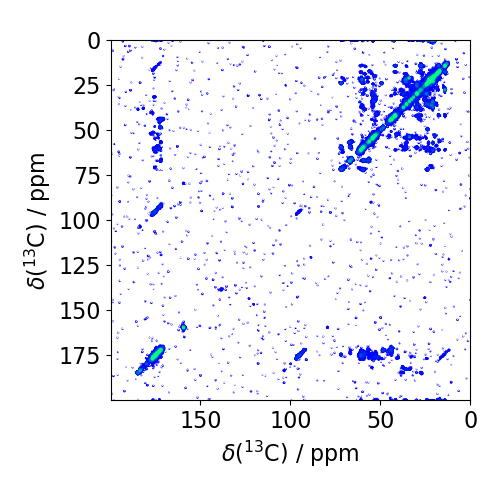

In [16]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,fftshift(S,1).T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
fig.set_size_inches([5,5])
fig.tight_layout()

# Echo-Antiecho

In [17]:
t=np.arange(TD)*dt

E=np.zeros((TD,TD),dtype=complex)
AE=np.zeros((TD,TD),dtype=complex)

phase=2*np.pi*np.random.rand(A.size) #Random phase of artifacts

for i,d1,l1,d2,l2,p in zip(A,delta1,lw1,delta2,lw2,phase):
    E+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)+\
        i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    AE+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)-\
        i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    
    #Artifacts
    E+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    AE+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    
# Noise level
E+=np.random.randn(*E.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl
AE+=np.random.randn(*AE.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl

In [18]:
Ire=(E+AE)/2
Iim=(E-AE)/2
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
Ire_a=((Ire*apod).T*apod).T
Iim_a=((Iim*apod).T*apod).T
Ire_a[0]/=2
Iim_a[0]/=2

SIre=fft(Ire_a.T,SI)
SIim=fft(Iim_a.T,SI)

SIre[0]/=2
SIim[0]/=2

S=fftshift(fft((SIre.real+1j*SIim.real).T,SI)).real

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


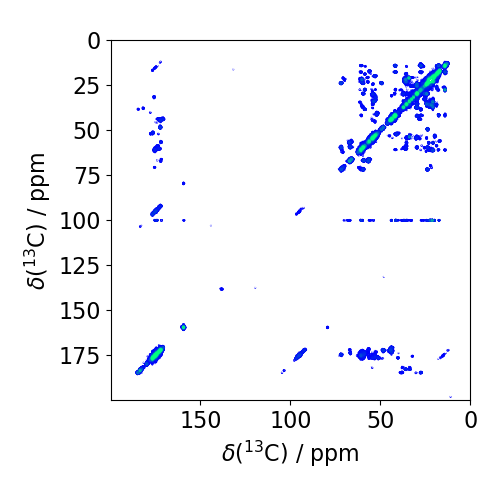

In [19]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,S.real.T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
ax.set_aspect('equal', 'box')
fig.set_size_inches([5,5])
fig.tight_layout()

# SPEPS

In [20]:
t=np.arange(TD)*dt

E=np.zeros((TD,TD),dtype=complex)
AE=np.zeros((TD,TD),dtype=complex)

phase=2*np.pi*np.random.rand(A.size) #Random phase of artifacts

for i,d1,l1,d2,l2,p in zip(A,delta1,lw1,delta2,lw2,phase):
    E+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)+\
        1j*i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    AE+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)-\
        1j*i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    
    #Artifacts
    E+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    AE+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t+1j*p)).T*.03
    
E+=np.random.randn(*E.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl
AE+=np.random.randn(*AE.shape)*np.exp(1j*2*np.pi*np.random.rand(*Ire.shape))*nl

In [21]:
Ire=(E+AE)/2
Iim=-1j*(E-AE)/2
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
Ire_a=((Ire*apod).T*apod).T
Iim_a=((Iim*apod).T*apod).T
Ire_a[0]/=2
Iim_a[0]/=2

SIre=fft(Ire_a.T,SI)
SIim=fft(Iim_a.T,SI)

SIre[0]/=2
SIim[0]/=2

S=fftshift(fft((SIre.real+1j*SIim.real).T,SI)).real

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


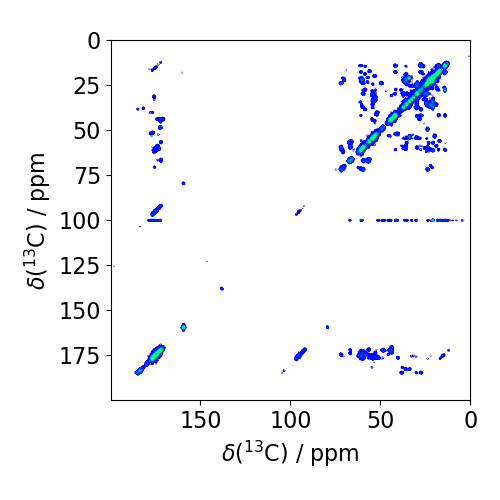

In [22]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,S.real.T,levels,cmap=plt.get_cmap('winter'))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$\delta$($^{13}$C) / ppm')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')
ax.set_aspect('equal', 'box')
fig.set_size_inches([5,5])
fig.tight_layout()